# Entrenando la arquitectura de SkinLesNet con imágenes de skin melanome

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.transforms import Resize
from torchvision.models import ResNet50_Weights, Inception_V3_Weights
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim
from tqdm import tqdm

from monai.utils import set_determinism

In [2]:
data_dir = '/Users/alzorrcarri/Library/CloudStorage/Dropbox/MICCAI/complete_mednode_dataset'
# data_dir = r"D:\alzor\Documents\Dropbox\MICCAI\complete_mednode_dataset"
melanoma_dir = data_dir + '/melanoma'
naevus_dir = data_dir + '/naevus'

In [3]:
set_determinism(seed = 0)

In [4]:
# Obtenemos los nombres de los ficheros en los directorios de melanoma y naevus
melanoma_files = [os.path.join(melanoma_dir, x) for x in os.listdir(melanoma_dir)]
naevus_files = [os.path.join(naevus_dir, x) for x in os.listdir(naevus_dir)]

In [5]:
# Cargamos las imágenes jpg de melanoma y naevus en un tensor de Pytorch
melanoma_images = []
naevus_images = []
for image in melanoma_files:
    melanoma_images.append(plt.imread(image))
for image in naevus_files:
    naevus_images.append(plt.imread(image))

In [6]:
len(melanoma_images), len(naevus_images)

(70, 100)

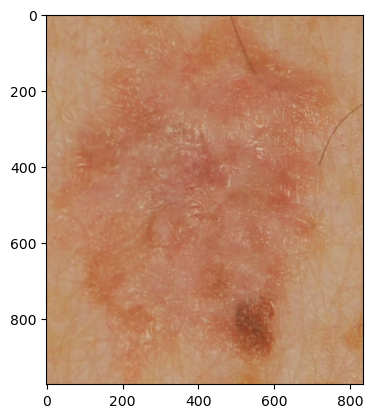

In [7]:
plt.imshow(melanoma_images[0])

In [8]:
# Transformamos las imágenes a tensores de Pytorch
melanoma_tensors = []
naevus_tensors = []
for image in melanoma_images:
    melanoma_tensors.append(torch.tensor(image))
for image in naevus_images:
    naevus_tensors.append(torch.tensor(image))

In [9]:
# Intercambiamos los ejes de las imágenes para que tengan el formato correcto
melanoma_tensors = [torch.transpose(image, 0, 2) for image in melanoma_tensors]
naevus_tensors = [torch.transpose(image, 0, 2) for image in naevus_tensors]

In [10]:
# Redimensionamos las imágenes a otro tamaño
IMAGE_SIZE = 128
resize = Resize((IMAGE_SIZE, IMAGE_SIZE))
melanoma_tensors_resized = []
naevus_tensors_resized = []
for image in melanoma_tensors:
    melanoma_tensors_resized.append(resize(image))
for image in naevus_tensors:
    naevus_tensors_resized.append(resize(image))

In [11]:
# Convertimos las listas de imágenes en tensores de Pytorch
melanoma_Tensor = torch.stack(melanoma_tensors_resized)
naevus_Tensor = torch.stack(naevus_tensors_resized)

# Normalizamos los tensores al rango [0,1]
melanoma_Tensor = melanoma_Tensor / 255
naevus_Tensor = naevus_Tensor / 255

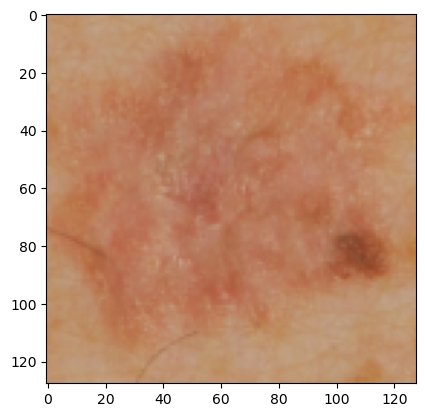

In [12]:
# Mostrar una imagen de melanoma
plt.imshow(melanoma_Tensor[0].permute(1, 2, 0))

In [13]:
train_images = torch.cat((melanoma_Tensor[0:50],naevus_Tensor[0:70]))
val_images = torch.cat((melanoma_Tensor[50:],naevus_Tensor[70:]))

train_labels = [1]*50 + [0]*70
val_labels = [1]*20 + [0]*30

In [14]:
train_dataset = [{'image': image, 'label': label} for image, label in zip(train_images, train_labels)]
val_dataset = [{'image': image, 'label': label} for image, label in zip(val_images, val_labels)]

In [15]:
# Creamos un DataLoader de Pytorch con el dataset
train_loader = DataLoader(train_dataset, batch_size = 2, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 2, shuffle = True)

In [16]:
device = torch.device("mps")

## Modelo 1: SkinLesNet

In [17]:
class ConvNet(nn.Module):
    def __init__(self, IMAGE_SIZE):
        super(ConvNet, self).__init__()
        # 1st Convolutional Input Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 2nd Convolutional Input Layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # 3rd Convolutional Layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        
        # 4th Convolutional Layer
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        self.dropout1 = nn.Dropout(0.5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16), 64)  # Adjusting for downsampling
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 2)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = self.dropout1(x)
        
        x = x.view(-1, 128 * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16))  # Flatten the tensor
        
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.softmax(self.fc2(x), dim=1)
        
        return x

model = ConvNet(IMAGE_SIZE).to(device)

print(model)

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=8192, out_features=64, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)


In [18]:
optimizer = optim.Adam(model.parameters(), lr=5e-05)
loss = nn.CrossEntropyLoss()
lr_sch = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                                        patience=0, threshold=0.0001, threshold_mode='rel', 
                                        cooldown=0, min_lr=0, eps=1e-08, verbose=False)

def calculate_accuracy(output, target):
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    return correct / target.size(0)

/opt/anaconda3/envs/tfm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [19]:
num_epochs = 100
loss_values = []
accuracy_train_values = []
accuracy_val_values = []
lr_values = [] 
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images_batch = batch['image'].to(device)
        labels_batch = batch['label'].to(device)
        output = model(images_batch)
        loss_value = loss(output, labels_batch.long())
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        epoch_loss += loss_value.item()
        epoch_accuracy += calculate_accuracy(output, labels_batch)
        progress_bar.set_postfix(loss=epoch_loss / (step + 1), accuracy=epoch_accuracy / (step + 1))
    loss_values.append(epoch_loss / len(train_loader))
    accuracy_train_values.append(epoch_accuracy / len(train_loader))
    lr_values.append(lr_sch.get_last_lr()[0])
    lr_sch.step(epoch_loss / (step + 1))

    if (epoch+1) % 5 == 0:
        model.eval()
        val_accuracy = 0.0
        with torch.no_grad():
            for step, batch in enumerate(val_loader):
                images_batch = batch['image'].to(device)
                labels_batch = batch['label'].to(device)
                output = model(images_batch)
                val_accuracy += calculate_accuracy(output, labels_batch)
        accuracy_val_values.append(val_accuracy / len(val_loader))
        print(f"Validation accuracy: {val_accuracy / len(val_loader)}")


Epoch 4: 100%|██████████| 60/60 [00:00<00:00, 94.61it/s, accuracy=0.6, loss=0.674]  


Validation accuracy: 0.6


Epoch 9: 100%|██████████| 60/60 [00:00<00:00, 98.36it/s, accuracy=0.725, loss=0.574] 


Validation accuracy: 0.64


Epoch 14: 100%|██████████| 60/60 [00:00<00:00, 101.77it/s, accuracy=0.742, loss=0.561]


Validation accuracy: 0.74


Epoch 19: 100%|██████████| 60/60 [00:00<00:00, 105.68it/s, accuracy=0.733, loss=0.555]


Validation accuracy: 0.76


Epoch 24: 100%|██████████| 60/60 [00:00<00:00, 101.00it/s, accuracy=0.75, loss=0.548] 


Validation accuracy: 0.76


Epoch 29: 100%|██████████| 60/60 [00:00<00:00, 103.21it/s, accuracy=0.75, loss=0.548] 


Validation accuracy: 0.76


Epoch 34: 100%|██████████| 60/60 [00:00<00:00, 102.89it/s, accuracy=0.733, loss=0.555]


Validation accuracy: 0.76


Epoch 39: 100%|██████████| 60/60 [00:00<00:00, 104.46it/s, accuracy=0.733, loss=0.557]


Validation accuracy: 0.76


Epoch 44: 100%|██████████| 60/60 [00:00<00:00, 102.86it/s, accuracy=0.75, loss=0.557] 


Validation accuracy: 0.76


Epoch 49: 100%|██████████| 60/60 [00:00<00:00, 103.59it/s, accuracy=0.767, loss=0.551]


Validation accuracy: 0.76


Epoch 54: 100%|██████████| 60/60 [00:00<00:00, 100.37it/s, accuracy=0.742, loss=0.554]


Validation accuracy: 0.76


Epoch 59: 100%|██████████| 60/60 [00:00<00:00, 106.94it/s, accuracy=0.75, loss=0.56]  


Validation accuracy: 0.76


Epoch 64: 100%|██████████| 60/60 [00:00<00:00, 106.45it/s, accuracy=0.75, loss=0.555] 


Validation accuracy: 0.76


Epoch 69: 100%|██████████| 60/60 [00:00<00:00, 102.79it/s, accuracy=0.725, loss=0.559]


Validation accuracy: 0.76


Epoch 74: 100%|██████████| 60/60 [00:00<00:00, 103.10it/s, accuracy=0.75, loss=0.556] 


Validation accuracy: 0.76


Epoch 79: 100%|██████████| 60/60 [00:00<00:00, 101.99it/s, accuracy=0.75, loss=0.548] 


Validation accuracy: 0.76


Epoch 84: 100%|██████████| 60/60 [00:00<00:00, 102.47it/s, accuracy=0.767, loss=0.55] 


Validation accuracy: 0.76


Epoch 89: 100%|██████████| 60/60 [00:00<00:00, 102.25it/s, accuracy=0.742, loss=0.556]


Validation accuracy: 0.76


Epoch 94: 100%|██████████| 60/60 [00:00<00:00, 103.96it/s, accuracy=0.742, loss=0.561]


Validation accuracy: 0.76


Epoch 99: 100%|██████████| 60/60 [00:00<00:00, 102.99it/s, accuracy=0.75, loss=0.55]  


Validation accuracy: 0.76


In [20]:
# Guardamos el modelo
torch.save(model.state_dict(), "/Users/alzorrcarri/Library/CloudStorage/Dropbox/MICCAI/results/skinlesnet_trained.pth")

In [21]:
# Escribir los valores de loss y accuracy para cada una de las épocas en un fichero
empty_string = ""
with open("/Users/alzorrcarri/Library/CloudStorage/Dropbox/MICCAI/results/skinlesnet_training.csv", 'w') as f:
    f.write('epoch,loss,accuracy_train,accuracy_val,learning_rate\n')
    i = 0
    for epoch in range(num_epochs):
        if (epoch+1) % 5 == 0:
            f.write(f"{epoch},{loss_values[epoch]},{accuracy_train_values[epoch]},{accuracy_val_values[i]},{lr_values[epoch]}\n")
            i+=1
        else:
            f.write(f"{epoch},{loss_values[epoch]},{accuracy_train_values[epoch]},{empty_string},{lr_values[epoch]}\n")

# Modelo 2: ResNet50 pre-entrenado

In [22]:
transform = ResNet50_Weights.IMAGENET1K_V2.transforms()

new_train_images = []
new_val_images = []
for image in train_images:
    image = transform(image)
    new_train_images.append(image)
new_train_images = torch.stack(new_train_images)
for image in val_images:
    image = transform(image)
    new_val_images.append(image)
new_val_images = torch.stack(new_val_images)

train_dataset = [{'image': image, 'label': label} for image, label in zip(new_train_images, train_labels)]
val_dataset = [{'image': image, 'label': label} for image, label in zip(new_val_images, val_labels)]

# Creamos un DataLoader de Pytorch con el dataset
train_loader = DataLoader(train_dataset, batch_size = 2, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 2, shuffle = True)

In [23]:
resnet50_model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

for param in resnet50_model.parameters():
    param.requires_grad = False

In [24]:
resnet50_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
class Net(nn.Module):
    def __init__(self, base_model):
        super(Net, self).__init__()
        self.base_model = base_model
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1000, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.base_model(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1) # Añadir aux a la salida para el cálculo del FID

    def feature_size(self):
        return self.base_model.fc.in_features

model2 = Net(resnet50_model).to(device)

In [26]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model2.parameters()), lr=5e-05)
loss = nn.CrossEntropyLoss()
lr_sch = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                                        patience=0, threshold=0.0001, threshold_mode='rel', 
                                        cooldown=0, min_lr=0, eps=1e-08, verbose=False)

In [27]:
num_epochs = 100
loss_values = []
accuracy_train_values = []
accuracy_val_values = []
lr_values = [] 
for epoch in range(num_epochs):
    model2.train()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images_batch = batch['image'].to(device)
        labels_batch = batch['label'].to(device)
        output = model2(images_batch)
        loss_value = loss(output, labels_batch.long())
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        epoch_loss += loss_value.item()
        epoch_accuracy += calculate_accuracy(output, labels_batch)
        progress_bar.set_postfix(loss=epoch_loss / (step + 1), accuracy=epoch_accuracy / (step + 1))
    loss_values.append(epoch_loss / len(train_loader))
    accuracy_train_values.append(epoch_accuracy / len(train_loader))
    lr_values.append(lr_sch.get_last_lr()[0])
    lr_sch.step(epoch_loss / (step + 1))

    if (epoch+1) % 5 == 0:
        model2.eval()
        val_accuracy = 0.0
        with torch.no_grad():
            for step, batch in enumerate(val_loader):
                images_batch = batch['image'].to(device)
                labels_batch = batch['label'].to(device)
                output = model2(images_batch)
                val_accuracy += calculate_accuracy(output, labels_batch)
        accuracy_val_values.append(val_accuracy / len(val_loader))
        print(f"Validation accuracy: {val_accuracy / len(val_loader)}")

Epoch 4: 100%|██████████| 60/60 [00:01<00:00, 50.49it/s, accuracy=0.725, loss=0.628]


Validation accuracy: 0.72


Epoch 9: 100%|██████████| 60/60 [00:01<00:00, 51.60it/s, accuracy=0.7, loss=0.611]  


Validation accuracy: 0.7


Epoch 14: 100%|██████████| 60/60 [00:01<00:00, 51.57it/s, accuracy=0.708, loss=0.608]


Validation accuracy: 0.74


Epoch 19: 100%|██████████| 60/60 [00:01<00:00, 51.72it/s, accuracy=0.725, loss=0.616]


Validation accuracy: 0.76


Epoch 24: 100%|██████████| 60/60 [00:01<00:00, 52.11it/s, accuracy=0.717, loss=0.603]


Validation accuracy: 0.76


Epoch 29: 100%|██████████| 60/60 [00:01<00:00, 51.94it/s, accuracy=0.717, loss=0.614]


Validation accuracy: 0.78


Epoch 34: 100%|██████████| 60/60 [00:01<00:00, 51.83it/s, accuracy=0.692, loss=0.618]


Validation accuracy: 0.72


Epoch 39: 100%|██████████| 60/60 [00:01<00:00, 51.91it/s, accuracy=0.725, loss=0.623]


Validation accuracy: 0.76


Epoch 44: 100%|██████████| 60/60 [00:01<00:00, 50.21it/s, accuracy=0.725, loss=0.595]


Validation accuracy: 0.76


Epoch 49: 100%|██████████| 60/60 [00:01<00:00, 51.92it/s, accuracy=0.65, loss=0.634] 


Validation accuracy: 0.68


Epoch 54: 100%|██████████| 60/60 [00:01<00:00, 50.91it/s, accuracy=0.642, loss=0.634]


Validation accuracy: 0.7


Epoch 59: 100%|██████████| 60/60 [00:01<00:00, 51.50it/s, accuracy=0.683, loss=0.608]


Validation accuracy: 0.7


Epoch 64: 100%|██████████| 60/60 [00:01<00:00, 52.33it/s, accuracy=0.692, loss=0.617]


Validation accuracy: 0.68


Epoch 69: 100%|██████████| 60/60 [00:01<00:00, 52.18it/s, accuracy=0.792, loss=0.587]


Validation accuracy: 0.72


Epoch 74: 100%|██████████| 60/60 [00:01<00:00, 52.50it/s, accuracy=0.642, loss=0.639]


Validation accuracy: 0.7


Epoch 79: 100%|██████████| 60/60 [00:01<00:00, 52.51it/s, accuracy=0.667, loss=0.63] 


Validation accuracy: 0.78


Epoch 84: 100%|██████████| 60/60 [00:01<00:00, 52.17it/s, accuracy=0.675, loss=0.618]


Validation accuracy: 0.7


Epoch 89: 100%|██████████| 60/60 [00:01<00:00, 52.15it/s, accuracy=0.675, loss=0.612]


Validation accuracy: 0.66


Epoch 94: 100%|██████████| 60/60 [00:01<00:00, 52.66it/s, accuracy=0.717, loss=0.621]


Validation accuracy: 0.74


Epoch 99: 100%|██████████| 60/60 [00:01<00:00, 52.74it/s, accuracy=0.7, loss=0.615]  


Validation accuracy: 0.72


In [28]:
# Guardamos el modelo
torch.save(model2.state_dict(), "/Users/alzorrcarri/Library/CloudStorage/Dropbox/MICCAI/results/resnet50_retrained.pth")

In [29]:
# Escribir los valores de loss y accuracy para cada una de las épocas en un fichero
with open("/Users/alzorrcarri/Library/CloudStorage/Dropbox/MICCAI/results/resnet50_retraining.csv", 'w') as f:
    f.write('epoch,loss,accuracy_train,accuracy_val,learning_rate\n')
    i=0
    for epoch in range(num_epochs):
        if (epoch+1) % 5 == 0:
            f.write(f"{epoch},{loss_values[epoch]},{accuracy_train_values[epoch]},{accuracy_val_values[i]},{lr_values[epoch]}\n")
            i+=1
        else:
            f.write(f"{epoch},{loss_values[epoch]},{accuracy_train_values[epoch]},{empty_string},{lr_values[epoch]}\n")

## Modelo 3: InceptionV3 pre-entrenado

In [30]:
transform = Inception_V3_Weights.IMAGENET1K_V1.transforms()

new_train_images = []
new_val_images = []
for image in train_images:
    image = transform(image)
    new_train_images.append(image)
new_train_images = torch.stack(new_train_images)
for image in val_images:
    image = transform(image)
    new_val_images.append(image)
new_val_images = torch.stack(new_val_images)

train_dataset = [{'image': image, 'label': label} for image, label in zip(new_train_images, train_labels)]
val_dataset = [{'image': image, 'label': label} for image, label in zip(new_val_images, val_labels)]

# Creamos un DataLoader de Pytorch con el dataset
train_loader = DataLoader(train_dataset, batch_size = 2, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 2, shuffle = True)

In [31]:
inceptionv3_model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)

for param in inceptionv3_model.parameters():
    param.requires_grad = False

inceptionv3_model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [32]:
class Net(nn.Module):
    def __init__(self, base_model):
        super(Net, self).__init__()
        self.base_model = base_model
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1000, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 2)

    def train(self, mode=True):
        super().train(mode)
        self.training = mode

    def eval(self):
        super().eval()

    def forward(self, x):
        if self.training:
            x, _ = self.base_model(x)
        else:
            x = self.base_model(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    def feature_size(self):
        return self.base_model.fc.in_features

In [33]:
model3 = Net(inceptionv3_model).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model3.parameters()), lr=5e-05)
loss = nn.CrossEntropyLoss()
lr_sch = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                                        patience=0, threshold=0.0001, threshold_mode='rel', 
                                        cooldown=0, min_lr=0, eps=1e-08, verbose=False)

In [34]:
num_epochs = 100
loss_values = []
accuracy_train_values = []
accuracy_val_values = []
lr_values = [] 
for epoch in range(num_epochs):
    model3.train()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images_batch = batch['image'].to(device)
        labels_batch = batch['label'].to(device)
        output = model3(images_batch)
        loss_value = loss(output, labels_batch.long())
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        epoch_loss += loss_value.item()
        epoch_accuracy += calculate_accuracy(output, labels_batch)
        progress_bar.set_postfix(loss=epoch_loss / (step + 1), accuracy=epoch_accuracy / (step + 1))
    loss_values.append(epoch_loss / len(train_loader))
    accuracy_train_values.append(epoch_accuracy / len(train_loader))
    lr_values.append(lr_sch.get_last_lr()[0])
    lr_sch.step(epoch_loss / (step + 1))

    if (epoch+1) % 5 == 0:
        model3.eval()
        val_accuracy = 0.0
        with torch.no_grad():
            for step, batch in enumerate(val_loader):
                images_batch = batch['image'].to(device)
                labels_batch = batch['label'].to(device)
                output = model3(images_batch)
                val_accuracy += calculate_accuracy(output, labels_batch)
        accuracy_val_values.append(val_accuracy / len(val_loader))
        print(f"Validation accuracy: {val_accuracy / len(val_loader)}")

Epoch 4: 100%|██████████| 60/60 [00:01<00:00, 31.40it/s, accuracy=0.692, loss=0.642]


Validation accuracy: 0.62


Epoch 9: 100%|██████████| 60/60 [00:01<00:00, 31.99it/s, accuracy=0.642, loss=0.635]


Validation accuracy: 0.76


Epoch 14: 100%|██████████| 60/60 [00:01<00:00, 32.19it/s, accuracy=0.6, loss=0.647]  


Validation accuracy: 0.7


Epoch 19: 100%|██████████| 60/60 [00:02<00:00, 28.33it/s, accuracy=0.675, loss=0.635]


Validation accuracy: 0.7


Epoch 24: 100%|██████████| 60/60 [00:01<00:00, 30.80it/s, accuracy=0.658, loss=0.641]


Validation accuracy: 0.66


Epoch 29: 100%|██████████| 60/60 [00:01<00:00, 31.51it/s, accuracy=0.667, loss=0.651]


Validation accuracy: 0.72


Epoch 34: 100%|██████████| 60/60 [00:01<00:00, 31.52it/s, accuracy=0.592, loss=0.641]


Validation accuracy: 0.7


Epoch 39: 100%|██████████| 60/60 [00:01<00:00, 31.54it/s, accuracy=0.617, loss=0.648]


Validation accuracy: 0.78


Epoch 44: 100%|██████████| 60/60 [00:01<00:00, 30.74it/s, accuracy=0.658, loss=0.638]


Validation accuracy: 0.7


Epoch 49: 100%|██████████| 60/60 [00:01<00:00, 31.16it/s, accuracy=0.667, loss=0.625]


Validation accuracy: 0.68


Epoch 54: 100%|██████████| 60/60 [00:01<00:00, 31.71it/s, accuracy=0.65, loss=0.64]  


Validation accuracy: 0.64


Epoch 59: 100%|██████████| 60/60 [00:01<00:00, 31.75it/s, accuracy=0.7, loss=0.63]   


Validation accuracy: 0.76


Epoch 64: 100%|██████████| 60/60 [00:01<00:00, 30.80it/s, accuracy=0.733, loss=0.613]


Validation accuracy: 0.66


Epoch 69: 100%|██████████| 60/60 [00:01<00:00, 31.44it/s, accuracy=0.683, loss=0.624]


Validation accuracy: 0.78


Epoch 74: 100%|██████████| 60/60 [00:01<00:00, 31.43it/s, accuracy=0.642, loss=0.64] 


Validation accuracy: 0.76


Epoch 79: 100%|██████████| 60/60 [00:01<00:00, 31.05it/s, accuracy=0.667, loss=0.631]


Validation accuracy: 0.7


Epoch 84: 100%|██████████| 60/60 [00:01<00:00, 31.59it/s, accuracy=0.65, loss=0.623] 


Validation accuracy: 0.72


Epoch 89: 100%|██████████| 60/60 [00:01<00:00, 31.54it/s, accuracy=0.658, loss=0.634]


Validation accuracy: 0.76


Epoch 94: 100%|██████████| 60/60 [00:01<00:00, 31.47it/s, accuracy=0.7, loss=0.635]  


Validation accuracy: 0.74


Epoch 99: 100%|██████████| 60/60 [00:01<00:00, 31.46it/s, accuracy=0.617, loss=0.658]


Validation accuracy: 0.66


In [35]:
# Guardamos el modelo
torch.save(model3.state_dict(), "/Users/alzorrcarri/Library/CloudStorage/Dropbox/MICCAI/results/inceptionv3_retrained.pth")

In [36]:
# Escribir los valores de loss y accuracy para cada una de las épocas en un fichero
with open("/Users/alzorrcarri/Library/CloudStorage/Dropbox/MICCAI/results/inceptionv3_retraining.csv", 'w') as f:
    f.write('epoch,loss,accuracy_train,accuracy_val,learning_rate\n')
    i=0
    for epoch in range(num_epochs):
        if (epoch+1) % 5 == 0:
            f.write(f"{epoch},{loss_values[epoch]},{accuracy_train_values[epoch]},{accuracy_val_values[i]},{lr_values[epoch]}\n")
            i+=1
        else:
            f.write(f"{epoch},{loss_values[epoch]},{accuracy_train_values[epoch]},{empty_string},{lr_values[epoch]}\n")